# Pytorch Text - Translation With A Sqeuence To Sequence Network and Attention
Notebook for following along with Pytorch Text NLP From Scratch tutorials that is looking at creating a NN to translate French to English [Pytorch](https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html)  website tutorial. <br><br>
The data can be downloaded [here](https://download.pytorch.org/tutorial/data.zip).

### Choices for data

<br>

### Libaries and Modules
Importing the necessary libaries and modules for the notebook.

In [1]:
#Import cell
import glob
import matplotlib as mpl
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import math
import numpy as np
import os
import pandas as pd
import pickle as pk
import random
import re
import string
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchtext
import unicodedata

from __future__ import unicode_literals, print_function, division
from io import open
from torch import optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}. Cuda available: {torch.cuda.is_available()}")
print("Imports complete")

Device: cpu. Cuda available: False
Imports complete


<br>

### Importing and preparing data sets
Importing and preparing the data for the models.

In [2]:
#Gather datasets and prepare them for consumption
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c)!= 'Mn')

def normalizeString(s):
    s = unicodeToAscii(s.lower().strip())
    s = re.sub(r"([.!?])", r" \1", s)
    s = re.sub(r"[^a-zA-Z.!?]+", r" ", s)
    return s

print("Data sets functions defined.")

Data sets functions defined.


In [3]:
#Importing data sets
def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
                read().strip().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)
    return input_lang, output_lang, pairs    

def readLangsEval(lang1, lang2, reverse=False):
    print("Reading lines...")
    lines = open('data/%s-%s.txt' % (lang1, lang2), encoding='utf-8').\
                read().strip().split('\n')
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]
    print(f"{len(pairs)} lines successfully read.")
    if reverse:
        pairs = [list(reversed(p)) for p in pairs]
    return pairs    
    
print("\nData sets successfully imported.")


Data sets successfully imported.


In [4]:
#Loader definitions

print(f"Loaders defined, running on device: {device}")

Loaders defined, running on device: cpu


In [5]:
#Setting seed value
torch.manual_seed(1247)

<br>

### Class Definitions
<b>Classes:</b><br>
<ul>
    <li>Lang - Language encoder that converts words into a single hot-vector.</li>
    <li>Encoder - Outputs some value for every word from the input sentence. For every input word the encord outputs a vector and a hidden state, which is used for the next input word.</li>
    <li>Decoder - takes the encoder output vector(s) and outputs a sequence of words to create the translation.</li>
</ul>

In [6]:
#Constants
SOS_token = 0
EOS_token = 1
MAX_LENGTH = 10

In [7]:
#Class definition cell
class Lang:
    def __init__(self, name) -> None:
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1:"EOS"}
        self.n_words = 2 #Count SOS and EOS
        return None
        
    def addSentence(self, sentence) -> None:
        for word in sentence.split(' '):
            self.addWord(word)
        return None
    
    def addWord(self, word) -> None:
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
        return None

    
class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size) -> None:
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        return None
    
    def forward(self, input, hidden):
        embedding = self.embedding(input).view(1, 1, -1)
        output = embedding
        output, hidden = self.gru(output, hidden)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size) -> None:
        super(DecoderRNN, self).init()
        self.hidden_size = hidden_size
        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        return None
    
    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)
    
    
class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length
        
        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size*2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size*2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)
        return None
    
    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        ebeded = self.dropout(embedded)
        
        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                encoder_outputs.unsqueeze(0))
        
        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights
    
    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

print("Classes defined.")

Classes defined.


<br>

### Calculation functions
<b>Functions:</b><br>
<ul>
    <li>filterPair - Checks if the data is below the length of MAX_LENGTH</li>
    <li>filterPairs - returns elements in a list if below the MAX_LENGTH</li>
    <li>prepareData - filters data by MAX_LENGTH, printing relevant information</li>
</ul>

In [8]:
#Calculation functions cell
def filterPair(p) -> bool:
    return len(p[0].split(' ')) < MAX_LENGTH and \
            len(p[1].split(' ')) < MAX_LENGTH and \
            p[1].startswith(eng_prefixes)

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs\n" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs\n" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words, "\n")
    return input_lang, output_lang, pairs

def prepareDataEval(lang1, lang2, reverse=False):
    pairs = readLangsEval(lang1, lang2, reverse)
    print("Read %s sentence pairs\n" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs\n" % len(pairs))
    return pairs
    
print("Calculation functions defined.")

Calculation functions defined.


<br>

### Plotting functions
<b>Functions:</b>
<ul>
    <li>evaluateAndShowAttention - runs input sentence through NLP model and calls showAttention to display attention matrix</li>
    <li>showAttention - displays attention matrix for input sentence</li>
    <li>showPlot - plots input array, used for plot_losses</li>
</ul>

In [9]:
#Plotting functions Cell
#plt.switch_backend('agg')
%matplotlib inline

def evaluateAndShowAttention(input_sentence, encoder, attn_decoder) -> None:
    output_words, attentions = evaluate(
        encoder, attn_decoder, input_sentence)
    print('input =', input_sentence)
    print('output =', ' '.join(output_words))
    showAttention(input_sentence, output_words, attentions)
    return None

def showAttention(input_sentence, output_words, attentions) -> None:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions.numpy(), cmap='bone')
    fig.colorbar(cax)
    ax.set_xticklabels(['']+input_sentence.split(' ')+['<EOS>'], rotation=90)
    ax.set_yticklabels(['']+output_words)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    plt.show()
    return None

def showPlot(points) -> None:
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)
    plt.title("Average Training Loss")
    plt.ylabel("Average Loss Value")
    plt.xlabel("Loss Check Point")
    return None
    
print("Plotting functions defined.")

Plotting functions defined.


<br>

### Main code

In [10]:
eng_prefixes = (
    "i am ", "i m ",
    "he is", "he s ",
    "she is", "she s ",
    "you are", "you re ",
    "we are", "we re ",
    "they are", "they re ")

#### Training Functions

In [11]:
#Training Preparation Functions
def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]

def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1,1)

def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang,pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

def asMinutes(s):
    return '%dm %ds' % (s//60, s%60)

def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s/percent
    rs = es - s
    return '%s (est: %s)' % (asMinutes(s), asMinutes(rs))

#### Evaluating Functions

In [12]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()
        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)
        
        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                    encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]
            
        decoder_input = torch.tensor([[SOS_token]], device=device)
        decoder_hidden = encoder_hidden
        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)
        
        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])
            decoder_input = topi.squeeze().detach()
            
        return decoded_words, decoder_attentions[:di+1]

    
def evaluateRandomly(encoder, decoder, n=10) -> None:
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')
    return None

### Importing Language Models

In [13]:
lang1 = 'fra'
lang2 = 'eng'

In [14]:
input_lang = Lang(lang1)
with open(f'{input_lang.name}_index2word.txt', 'r') as f:
    input_lang_text = f.read()
    f.close()
    
for pair in input_lang_text.split(', ')[2:]:
    num, word = pair.split(': ')
    input_lang.addWord(word.strip("''"))

for i in range(2, input_lang.n_words):
    assert input_lang.word2index[input_lang.index2word[i]] == i, str(input_lang.index2word[i])+ " doesnt equal "+ str(i)+" gives value "+str(input_lang.word2index[input_lang.index2word[i]])
    
print(f"{input_lang.n_words} properly reloaded into input_lang: {input_lang.name}")

4345 properly reloaded into input_lang: fra


In [15]:
output_lang = Lang(lang2)
with open(f'{output_lang.name}_index2word.txt', 'r') as f:
    output_lang_text = f.read()
    f.close()
    
for pair in output_lang_text.split(', ')[2:]:
    num, word = pair.split(': ')
    output_lang.addWord(word.strip("''"))

for i in range(2, output_lang.n_words):
    assert output_lang.word2index[output_lang.index2word[i]] == i, str(output_lang.index2word[i])+ " doesnt equal "+ str(i)+" gives value "+str(output_lang.word2index[output_lang.index2word[i]])
    
print(f"{output_lang.n_words} properly reloaded into input_lang: {output_lang.name}")

2803 properly reloaded into input_lang: eng


### Reloading the Model

In [16]:
with open(f'{input_lang.name}_{output_lang.name}_meta.txt', 'r') as f:
    fileContents = f.read()
    f.close()
   
fileContents = [lineRead.split(' ') for lineRead in fileContents.split('\n')]
fileContents.pop() #removes empty end line

for descript, value in fileContents:
    match descript:
        case 'hidden_size:':
            hidden_size = int(value)
            print(f"Hidden_size: {hidden_size}")
        case 'input_lang.n_words:':
            assert input_lang.n_words == int(value)
            print(f"Input language name: {input_lang.name}")
        case 'output_lang.n_words:':
            print(f"Output language name: {output_lang.name}")
            assert output_lang.n_words == int(value)
        case 'Attn_additional: dropout_p=':
            dropout_pVal = int(value)
            print(f"droppit_pVal: {dropout_pVal}")
        case _:
            continue

Hidden_size: 256
Input language name: fra
Output language name: eng


In [17]:
encoderReload = EncoderRNN(input_lang.n_words, hidden_size)
encoderReload.load_state_dict(torch.load(f'encoder_{input_lang.name}_{output_lang.name}_weights.pth'))
encoderReload.eval()

EncoderRNN(
  (embedding): Embedding(4345, 256)
  (gru): GRU(256, 256)
)

In [18]:
attn_decoderReload = AttnDecoderRNN(hidden_size, output_lang.n_words,
                               dropout_p=0.1)
attn_decoderReload.load_state_dict(torch.load(f'attn_decoder_{input_lang.name}_{output_lang.name}_weights.pth'))
attn_decoderReload.eval()

AttnDecoderRNN(
  (embedding): Embedding(2803, 256)
  (attn): Linear(in_features=512, out_features=10, bias=True)
  (attn_combine): Linear(in_features=512, out_features=256, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (gru): GRU(256, 256)
  (out): Linear(in_features=256, out_features=2803, bias=True)
)

### Reload Test

In [19]:
pairs = prepareDataEval(lang2, lang1, reverse=True)

Reading lines...
135842 lines successfully read.
Read 135842 sentence pairs

Trimmed to 10599 sentence pairs



In [20]:
evaluateRandomly(encoderReload, attn_decoderReload)

> je suis maladroit .
= i m all thumbs .
< i m excited . <EOS>

> nous sommes les dernieres .
= we re the last .
< we re the last . <EOS>

> il est en train de dessiner une image .
= he is drawing a picture .
< he is painting a picture . <EOS>

> je suis decu .
= i m disappointed .
< i m disappointed . <EOS>

> je ne suis pas ta servante .
= i m not your servant .
< i m not your maid . <EOS>

> je ne suis pas bon dans la simulation .
= i m not good at pretending .
< i m not good at . . <EOS>

> c est pour vous que je suis venue .
= you re the reason i came .
< you re the reason i came . <EOS>

> je suis desole d etre en retard .
= i m sorry for being late .
< i m sorry i m so late . <EOS>

> je me sens beaucoup mieux aujourd hui .
= i m feeling much better today .
< i m really better today today . <EOS>

> je romps ce soir avec ma petite amie .
= i m breaking up with my girlfriend tonight .
< i m breaking up with my girlfriend . <EOS>



input = elle a cinq ans de moins que moi .
output = she s five years younger than i am . <EOS>


C:\Users\ellaw\AppData\Local\Temp\ipykernel_32860\158124480.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+input_sentence.split(' ')+['<EOS>'], rotation=90)
C:\Users\ellaw\AppData\Local\Temp\ipykernel_32860\158124480.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+output_words)


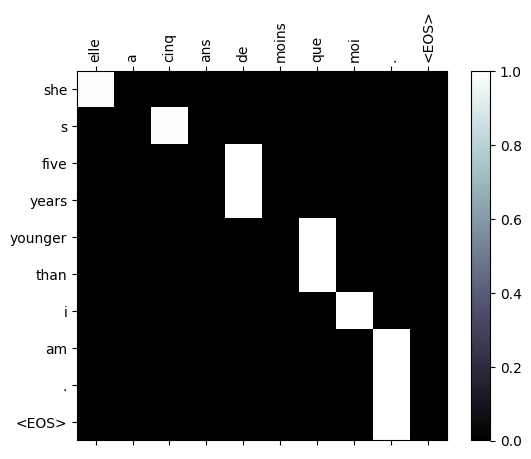

input = elle est trop petit .
output = she is too loud . <EOS>


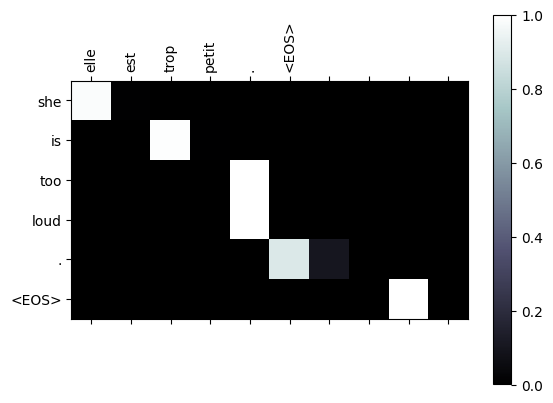

input = je ne crains pas de mourir .
output = i m not scared to die . <EOS>


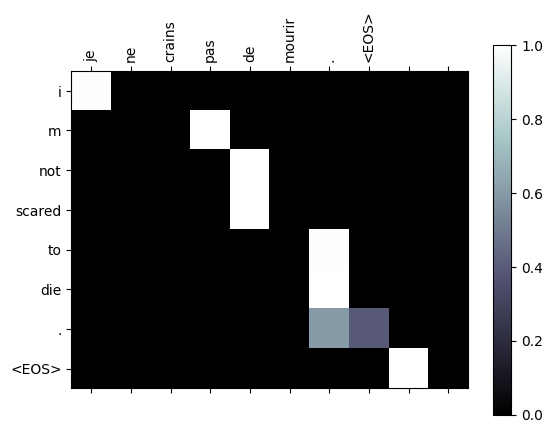

input = c est un jeune directeur plein de talent .
output = he s a very young man . . <EOS>


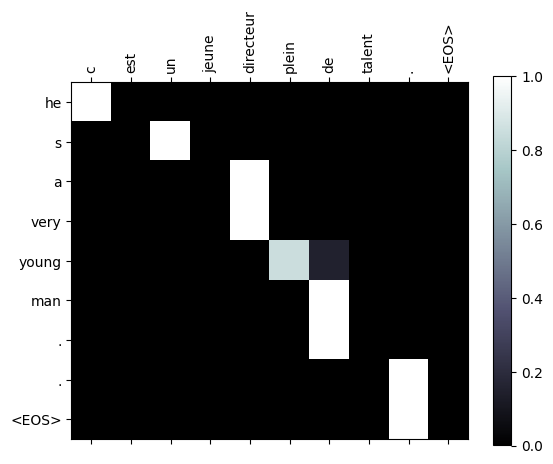

In [21]:
#Evaluation matrix for test input sentences
evaluateAndShowAttention("elle a cinq ans de moins que moi .", encoderReload, attn_decoderReload)
evaluateAndShowAttention("elle est trop petit .", encoderReload, attn_decoderReload)
evaluateAndShowAttention("je ne crains pas de mourir .", encoderReload, attn_decoderReload)
evaluateAndShowAttention("c est un jeune directeur plein de talent .", encoderReload, attn_decoderReload)

<br>